In [147]:
import graph_tool as gt
from graph_tool.spectral import adjacency
from graph_tool.topology import shortest_distance
import matplotlib.pylab as pl
%matplotlib inline
import numpy as np
import numpy.random as npr
import scipy.sparse as sps
import tqdm

In [148]:
src = np.load('models/hotpot_models/src.npy')
dst = np.load('models/hotpot_models/dst.npy')
n_vertices = max(src.max(), dst.max()) + 1
g = gt.Graph(directed=False)
g.add_vertex(n_vertices)
g.add_edge_list(np.vstack([src, dst]).T)
a = adjacency(g)

In [18]:
a.sum(0).max(), a.sum(1).max()

(189431.0, 189431.0)

In [22]:
from multiprocessing import Pool
from multiprocessing.pool import ThreadPool
from functools import partial

In [40]:
dists = [shortest_distance(g, u, v, directed=False, max_dist=10) for u, v in tqdm.tqdm(zip(gold0, gold1))]

7405it [05:41, 21.68it/s]


In [ ]:
with ThreadPool() as pool:
    dists = list(tqdm.tqdm(pool.starmap(partial(shortest_distance, g, directed=False, max_dist=10), zip(gold0, gold1))))

In [44]:
_dists = np.array(dists)

In [51]:
_dists.min(), _dists.max(), np.quantile(_dists, 0.99)

(1, 2147483647, 5.0)

In [84]:
nz, = np.nonzero(degree > np.quantile(degree, 0.995))

In [125]:
np.quantile(degree, 0.995)

82.0

In [150]:
a = adjacency(g).minimum(1)
d = np.asarray(a.sum(0)).squeeze().astype(np.int)
gt = d > np.quantile(d, 0.99)
a.data[gt.repeat(d)] = 0
a.eliminate_zeros()
a = a.transpose()
a.sum(0).max(), a.sum(1).max()

(45.0, 187315.0)

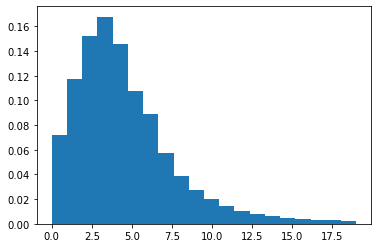

In [69]:
_ = pl.hist(degree[degree < 20], bins=20, density=True)

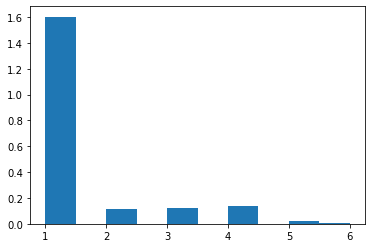

In [56]:
_ = pl.hist(_dists[_dists < 10], density=True)

In [115]:
gold0 = np.load('models/hotpot_models/gold0.npy')
gold1 = np.load('models/hotpot_models/gold1.npy')
data = np.ones(len(gold0))
indptr = np.arange(len(gold0) + 1)
_gold0 = sps.csr_matrix((data, gold0, indptr), shape=(len(gold0), n_vertices)).transpose()
_gold1 = sps.csr_matrix((data, gold1, indptr), shape=(len(gold1), n_vertices)).transpose()
gold = _gold0 + _gold1

In [20]:
k = 10
indices = np.load('models/hotpot_models/top%d_indices.npy' % k)
indptr = np.arange(0, len(indices) + 1, k)
data = np.ones_like(indices)
topk = sps.csr_matrix((data, indices, indptr), shape=(len(indices) // k, n_vertices)).transpose()

In [39]:
unique, counts = np.unique(np.asarray(topk.multiply(gold).sum(0)), return_counts=True)
unique, counts / len(gold0)

(array([0., 1., 2.]), array([0.156921  , 0.55881161, 0.28426739]))

In [153]:
visited = sps.csr_matrix(frontier.shape)
# frontier = _gold0; target = _gold1
# frontier = _gold1; target = _gold0
frontier = gold; target = gold
# frontier = topk; target = _gold0
# frontier = topk; target = _gold1
# frontier = visited = topk; target = gold
for i in range(3):
    frontier = a @ frontier
    frontier.data = np.ones_like(frontier.data) * (npr.rand(len(frontier.data)) <= 1)
    frontier.eliminate_zeros()
    visited = frontier + visited
    visited = visited.minimum(1)
    unique, counts = np.unique(np.asarray(target.multiply(visited).sum(0)), return_counts=True)
    print(f'{i + 1}-hop', np.quantile(visited.sum(0), 0.95), unique, counts / len(gold0))

1-hop 46.0 [0. 1. 2.] [0.20459149 0.2221472  0.57326131]
2-hop 302.0 [0. 1. 2.] [0.01634031 0.1027684  0.88089129]
3-hop 1986.5999999999985 [0. 1. 2.] [0.01634031 0.101553   0.88210668]


1-hop 82.0 [0. 1.] [0.20823768 0.79176232]
2-hop 1367.0 [0. 1.] [0.2055368 0.7944632]
3-hop 10233.0 [0. 1.] [0.20108035 0.79891965]
4-hop 59494.0 [0. 1.] [0.18176907 0.81823093]
5-hop 278929.0 [0. 1.] [0.15381499 0.84618501]